# "Smart" Gesture Recognition


**Business Proposal**

Nowadays, technology has a pivotal role in creating virtual environments with virtual elements. We work collaboratively with real-world intelligent objects on a day-to-day basis. Innovations like the Internet of things (IoT) products, gesture recognition, and teleportation application have certainly made our life "smarter" and more accessible.   


Embracing an "implementing a smarter life" mindset, Team College aims to develop a cool feature in the smart TV that can recognize five different gestures performed by the user to help users control the TV without using a remote. Based on this dataset, Team College wants to develop a well-rounded deep learning gesture recognition model which has applications in a spectrum of different industries beyond smart-TV. 

**Dataset Description**
The data consists of a few hundred videos categorized into five classes: thumb up, thumb down, swipe left, swipe right, stop. The webcam mounted on the TV continuously monitors the gestures. Each motion corresponds to a specific command:    
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

The training data consists of 19,890 images (663*30): there are 663 videos categorized into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). The testing data consists of a total of 3,000 images.	  

Various people have recorded these videos performing one of the five gestures in front of a webcam - like what the smart TV will use. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos) 

### Team College Objectives:
1. **Data Preprocessing_Generator Establishment**:  Team College aim to build a function called "Generator" so that this fuction should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Experimentation _ Model Architecture**: Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, Conv3D with Maxpolling 3D, RNN, CNN LSTM with GRU (for augmentation) models will be used to tackle the problem. 

3. **Best Performing Model**: Further Development and Tryouts such as Generative Adversarial Networks (GAN) , Different Batch Size, Learning Rate and tansfer learning method will be applied to design the best performing Model.

# Housekeeping Setup

## Prerequisite: install and import libraries

In [1]:
pip install tensorflow

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-image

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imageio

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sys import getsizeof
from imageio import imread
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from skimage.transform import resize

import abc
import cv2
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import random as rn
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

Setp for GPU check, if you have it, lucky you; ifelse, this might take some time to compute :)

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


We set the random seed as 28 to ensure the steady outcome

In [8]:
np.random.seed(28)
rn.seed(28)
tf.random.set_seed(28)

In [9]:
project_folder='./Project_data'

Generic plot function

In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

# 1. Generator

## 1.1 Load Data under `initialize_path()`

- No. training sequences = 530
- No. validation sequences = 133
- No. testing sequences = 100

train-val-test = 70% - 17% - 13%

## 1.2 Data EDA
Sample train and val dataset display as follow:
- train_doc contains 662 datapoints
- val-doc contains 100 datapoints

## 1.3 Data Preprocessing 
Following steps are followed:
1. Resized the image and cropped smaller image shape at center for 120*120
2. Normalized Images
3. Built 3D and 2D filter function <font color=red>(going to add it soon!)</font>
4. Established function to get batch data for preprocessing Convo3D

## 1.4 Generator Establishment under `generator()`
Since the dataset contains 2 types of dimensions, a "generator" is build to preprocess the images for `2D` and `3D` dimensions, as well as create `a batch of video frames`. We experiment with `img_idx`, `y`,`z` and normalization such that to achieve a high accuracy outcome.

Note: a video is represented above in the generator as (number of images, height, width, number of channels)

## 1.5 Model Callbacks Setup with CheckPoint, Earlystop & Tensorboard Callbacks

In [11]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.test_doc = np.random.permutation(open(project_folder + '/' + 'test.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.test_path = project_folder + '/' + 'test'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_test_sequences = len(self.test_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
       
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False, more_augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment,more_augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,more_augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,more_augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(',')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(',')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))                
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                    if(more_augment):
                        M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                    np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))                    

                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(',')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False, more_augment=False, early_stop=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data,more_augment=more_augment)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        
        if(early_stop):
            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]
        
        if(early_stop):
            callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# 2. Model

## Model Building
Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, following Models have been used for tryouts:

1. `Conv3D` with `MaxPooling3D` for a 3D convolution model 
2. `TimeDistributed` while building a Conv2D + RNN model
3. `Transfer Learning`

Moreover, for each model, we set the last layer is the softmax so that the least number of parameters can fit in the memory of the webcam. Hence to perform a good accuracy on the least number of parameters.

## A. Base model 

In [16]:
class BaseModel(ModelBuilder):
    def define_model(self):
        model = Sequential()
        return model

<font color=red>Shuyi, please add the scenarios below</font>

### A.1 Scenario 1

### A.2 Scenario 2

### A.3 Scenario 3

### A.4 Scenario 4

### A.5 Scenario 5

## B. Conv3D and MaxPooling3D model

In [12]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

2022-03-18 10:06:27.123016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

### Generator Validation

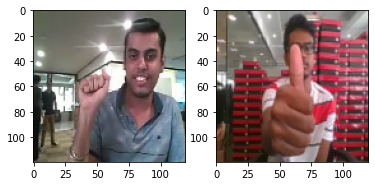

In [22]:
g=conv_3d1.generator(conv_3d1.val_path,conv_3d1.val_doc,augment=True,more_augment=False)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

In [23]:
print("Total Params:", conv_3d1_model.count_params())

Total Params: 900805


### B.1 Without Callback and Augmentation

In [24]:
history_conv_3d1_model=conv_3d1.train_model(conv_3d1_model,augment_data=True,more_augment=False,early_stop=False)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.7452 - categorical_accuracy: 0.3830
Epoch 1: saving model to model_init_2022-03-1802_15_36.749821/model-00001-1.74520-0.38302-12.24610-0.12782.h5
67/67 [==============================] - 351s 5s/step - loss: 1.7452 - categorical_accuracy: 0.3830 - val_loss: 12.2461 - val_categorical_accuracy: 0.1278 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3595 - categorical_accuracy: 0.4547
Epoch 2: saving model to model_init_2022-03-1802_15_36.749821/model-00002-1.35954-0.45472-15.86768-0.15789.h5
67/67 [==============================] - 359s 5s/step - loss: 1.3595 - categorical_accuracy: 0.4547 - val_loss: 15.8677 - val_categorical_accuracy: 0.1579 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.2020 - categorical_accuracy: 0.5330
Epoch 3: saving model to model_init_2022-03-1802_15_36.749821/model-00003-1.20201-0.53302-14.14789-0.09774.h5
67/67 [=========

Epoch 22/30
67/67 [==============================] - ETA: 0s - loss: 0.4742 - categorical_accuracy: 0.8311
Epoch 22: saving model to model_init_2022-03-1802_15_36.749821/model-00022-0.47421-0.83113-0.80578-0.72180.h5
67/67 [==============================] - 358s 5s/step - loss: 0.4742 - categorical_accuracy: 0.8311 - val_loss: 0.8058 - val_categorical_accuracy: 0.7218 - lr: 2.0000e-04
Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.4593 - categorical_accuracy: 0.8377
Epoch 23: saving model to model_init_2022-03-1802_15_36.749821/model-00023-0.45933-0.83774-0.95613-0.68421.h5
67/67 [==============================] - 366s 5s/step - loss: 0.4593 - categorical_accuracy: 0.8377 - val_loss: 0.9561 - val_categorical_accuracy: 0.6842 - lr: 2.0000e-04
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.4156 - categorical_accuracy: 0.8453
Epoch 24: saving model to model_init_2022-03-1802_15_36.749821/model-00024-0.41560-0.84528-0.63999-0.72180.h5
67/67 [

Max. Training Accuracy 0.8792452812194824
Max. Validaiton Accuracy 0.7744361162185669


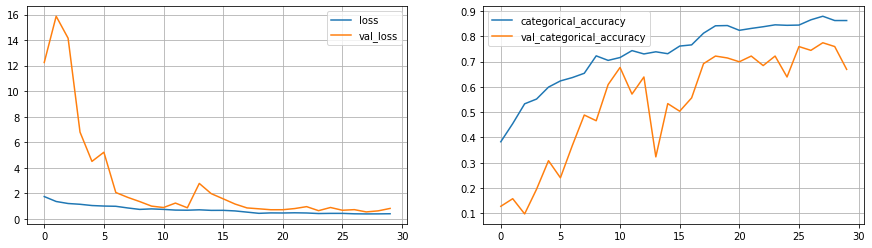

In [25]:
plot(history_conv_3d1_model)

### B.2 With Callback and No Augmentation

In [14]:
conv_3d1_w_cb=ModelConv3D1()
conv_3d1_w_cb.initialize_path(project_folder)
conv_3d1_w_cb.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_w_cb.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_w_cb_model=conv_3d1_w_cb.define_model()
conv_3d1_w_cb_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [15]:
history_conv_3d1_model_with_callback=conv_3d1_w_cb.train_model(conv_3d1_w_cb_model,augment_data=True,more_augment=False,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6842 - categorical_accuracy: 0.3670
Epoch 1: val_loss improved from inf to 4.10609, saving model to model_init_2022-03-1810_06_44.148547/model-00001-1.68416-0.36698-4.10609-0.25564.h5
67/67 [==============================] - 372s 6s/step - loss: 1.6842 - categorical_accuracy: 0.3670 - val_loss: 4.1061 - val_categorical_accuracy: 0.2556 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3208 - categorical_accuracy: 0.4802
Epoch 2: val_loss did not improve from 4.10609
67/67 [==============================] - 372s 6s/step - loss: 1.3208 - categorical_accuracy: 0.4802 - val_loss: 7.2055 - val_categorical_accuracy: 0.2180 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.1524 - categorical_accuracy: 0.5538
Epoch 3: val_loss did not improve from 4.10609
67/67 [==============================] - 374s 6s/step - loss: 1.1524 - categorical_accuracy: 0.5538 - val_

Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.3957 - categorical_accuracy: 0.8698
Epoch 23: val_loss did not improve from 0.50843
67/67 [==============================] - 356s 5s/step - loss: 0.3957 - categorical_accuracy: 0.8698 - val_loss: 0.8030 - val_categorical_accuracy: 0.6767 - lr: 2.0000e-04
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.4084 - categorical_accuracy: 0.8519
Epoch 24: val_loss did not improve from 0.50843
67/67 [==============================] - 351s 5s/step - loss: 0.4084 - categorical_accuracy: 0.8519 - val_loss: 0.7513 - val_categorical_accuracy: 0.7293 - lr: 2.0000e-04
Epoch 25/30
67/67 [==============================] - ETA: 0s - loss: 0.3500 - categorical_accuracy: 0.8830
Epoch 25: val_loss did not improve from 0.50843
67/67 [==============================] - 352s 5s/step - loss: 0.3500 - categorical_accuracy: 0.8830 - val_loss: 0.6074 - val_categorical_accuracy: 0.7669 - lr: 2.0000e-04
Epoch 26/30
67/67 [===

Max. Training Accuracy 0.900943398475647
Max. Validaiton Accuracy 0.8120300769805908


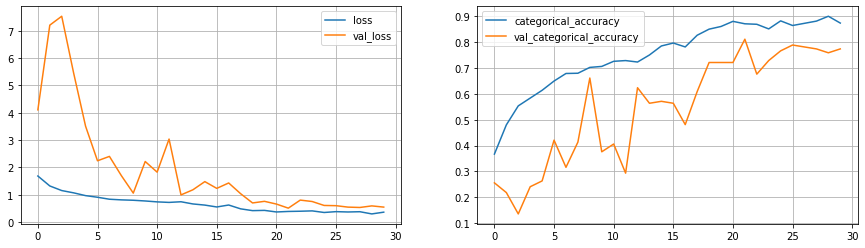

In [17]:
plot(history_conv_3d1_model_with_callback)

### B.3 With Callback and Augmentation

In [18]:
conv_3d1_w_cb_a=ModelConv3D1()
conv_3d1_w_cb_a.initialize_path(project_folder)
conv_3d1_w_cb_a.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_w_cb_a.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
conv_3d1_w_cb_a_model=conv_3d1_w_cb_a.define_model()
conv_3d1_w_cb_a_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
history_conv_3d1_model_with_callback_augmentation=conv_3d1_w_cb_a.train_model(conv_3d1_w_cb_a_model,augment_data=True,more_augment=True,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6528 - categorical_accuracy: 0.4009
Epoch 1: val_loss improved from inf to 3.48687, saving model to model_init_2022-03-1813_19_35.862486/model-00001-1.65281-0.40094-3.48687-0.19549.h5
67/67 [==============================] - 353s 5s/step - loss: 1.6528 - categorical_accuracy: 0.4009 - val_loss: 3.4869 - val_categorical_accuracy: 0.1955 - lr: 0.0010
Epoch 2/30
13/67 [====>.........................] - ETA: 4:28 - loss: 1.3964 - categorical_accuracy: 0.4471

In [ ]:
plot(history_conv_3d1_model_with_callback_augmentation)

### B.4 With Callback and Augmentation by using ELU

Based on B.3, we replace the RELU by ELU to see if there is any improvement

### B.5 With Callback and Augmentation by using colorful images

## B. Conv2D + RNN model

In [ ]:
class RNNCNN2(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

## C. Transfer Learning

# 3. Model Prediction for Best Model